# Week 2 pratcical 

In [1]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [3]:
airports = pd.read_csv(DATA_DIRECTORY / "airports.dat", delimiter=',', 
                       names=['id', 'name', 'city', 'country', 'iata', 
                              'icao', 'lat', 'long', 'altitude', 'timezone',
                              'dst', 'tz', 'type', 'source'])

In [4]:
print(airports.columns)

Index(['id', 'name', 'city', 'country', 'iata', 'icao', 'lat', 'long',
       'altitude', 'timezone', 'dst', 'tz', 'type', 'source'],
      dtype='object')


In [5]:
airport_geometry = [Point(xy) for xy in zip(airports['long'], 
                                            airports['lat'])]
airport_geodata = gpd.GeoDataFrame(airports, 
                                   crs="EPSG:4326", 
                                   geometry=airport_geometry)

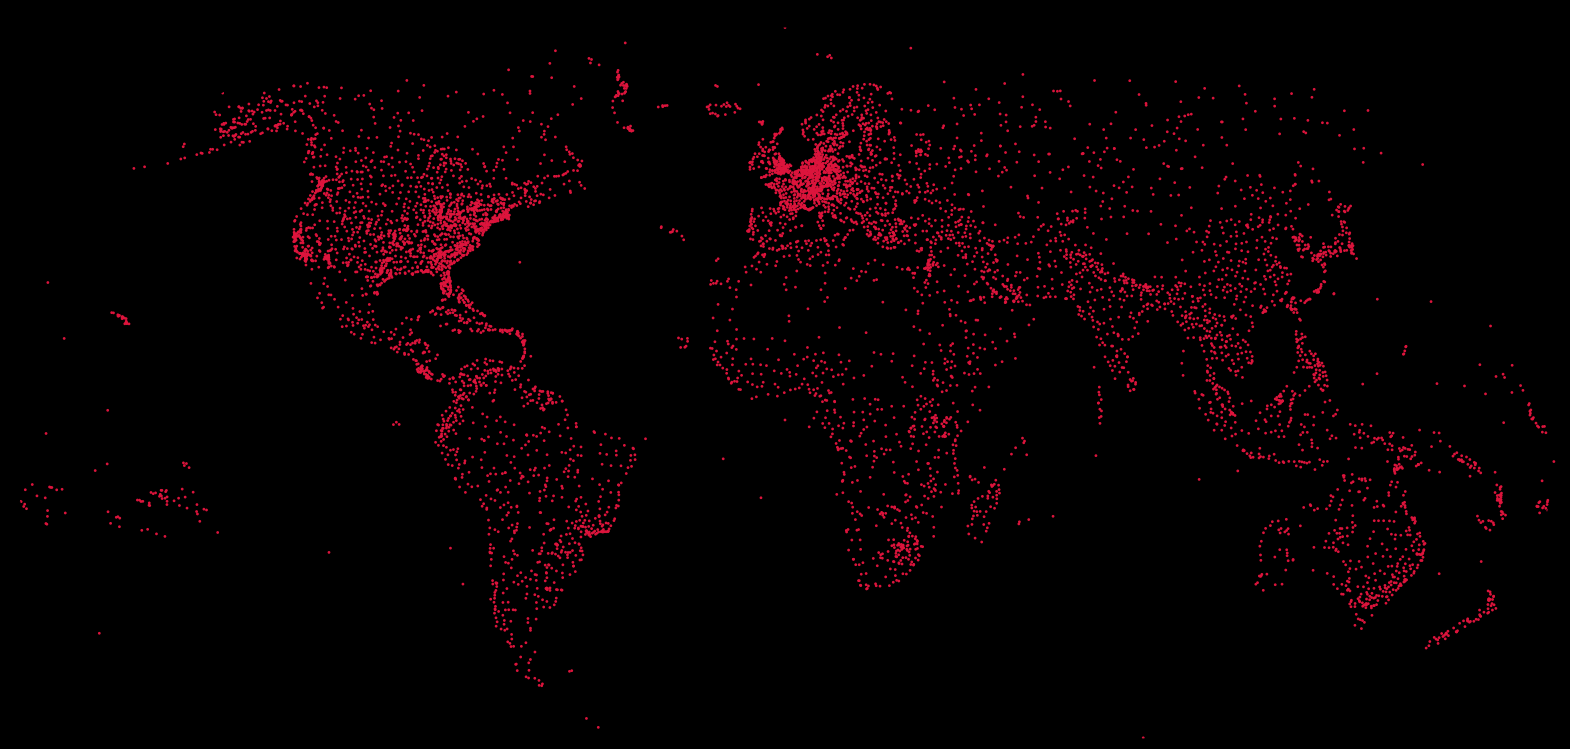

In [6]:
fig, ax = plt.subplots(facecolor='black', 
                       subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')

airport_geodata.plot(ax=ax, transform=ccrs.PlateCarree(), 
                     markersize=4, alpha=1, color='crimson', 
                     edgecolors='none')
plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 9000000)
plt.show()

In [7]:
routes = pd.read_csv(DATA_DIRECTORY / "routes.dat", 
                     delimiter=',', 
                     names=['airline', 'id', 'source_airport', 
                            'source_airport_id', 'destination_airport', 
                            'destination_airport_id', 'codeshare',
                            'stops', 'equitment'])

In [8]:
print(routes.columns)

Index(['airline', 'id', 'source_airport', 'source_airport_id',
       'destination_airport', 'destination_airport_id', 'codeshare', 'stops',
       'equitment'],
      dtype='object')


In [9]:
source_airports = airports[['name', 'iata', 'icao', 'lat', 'long']]
destination_airports = source_airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

In [10]:
routes = routes[['source_airport', 'destination_airport']]
routes = pd.merge(routes, 
                  source_airports, 
                  left_on='source_airport', 
                  right_on='iata_source')
routes = pd.merge(routes, 
                  destination_airports, 
                  left_on='destination_airport', 
                  right_on='iata_destination')

In [11]:
print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


In [12]:
from shapely.geometry import LineString

routes_geometry = [LineString([[routes.iloc[i]['long_source'], 
                                routes.iloc[i]['lat_source']], 
                               [routes.iloc[i]['long_destination'], 
                                routes.iloc[i]['lat_destination']]]) 
                   for i in range(routes.shape[0])]

routes_geodata = gpd.GeoDataFrame(routes, 
                                  geometry=routes_geometry, 
                                  crs='EPSG:4326')

In [13]:
print(routes.columns)

Index(['source_airport', 'destination_airport', 'name_source', 'iata_source',
       'icao_source', 'lat_source', 'long_source', 'name_destination',
       'iata_destination', 'icao_destination', 'lat_destination',
       'long_destination'],
      dtype='object')


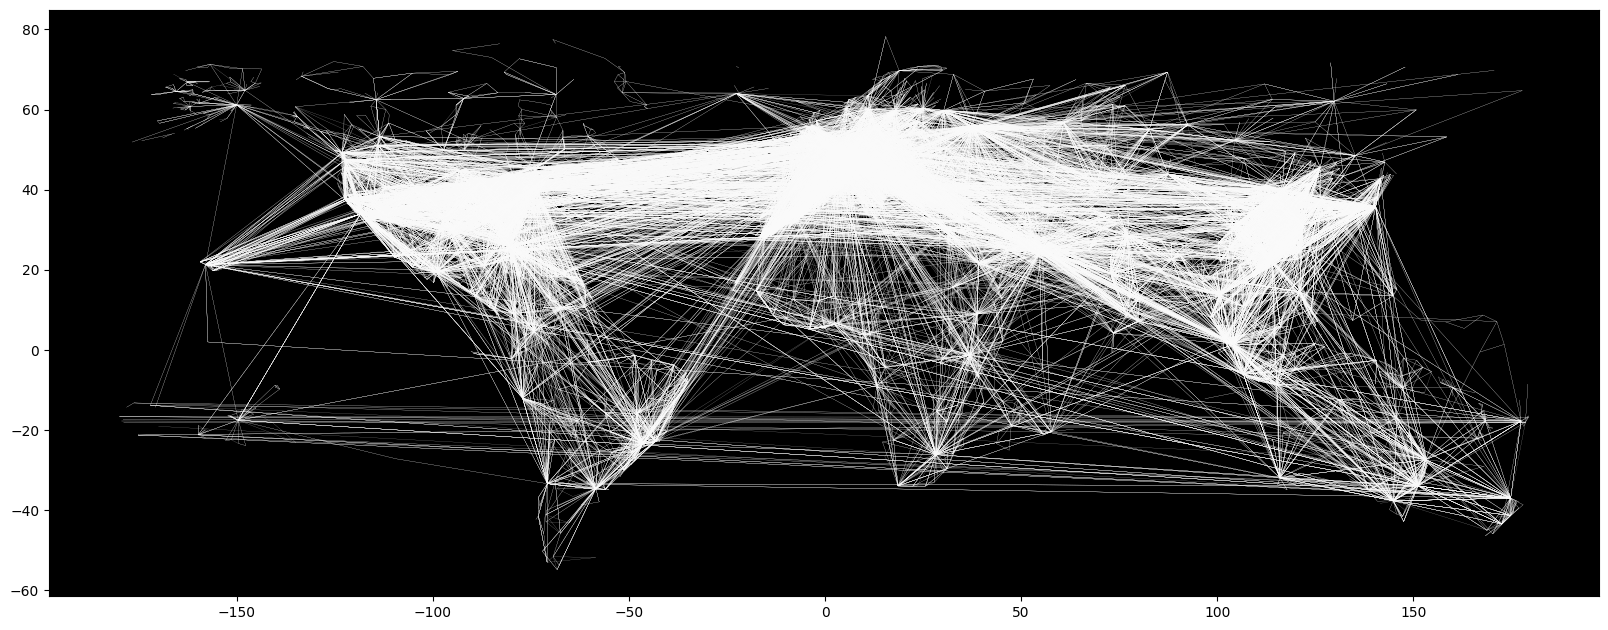

In [14]:
fig, ax = plt.subplots(figsize=(20,20))
ax.patch.set_facecolor('black')

routes_geodata.plot(ax=ax, color='white', linewidth=0.1)

plt.show()

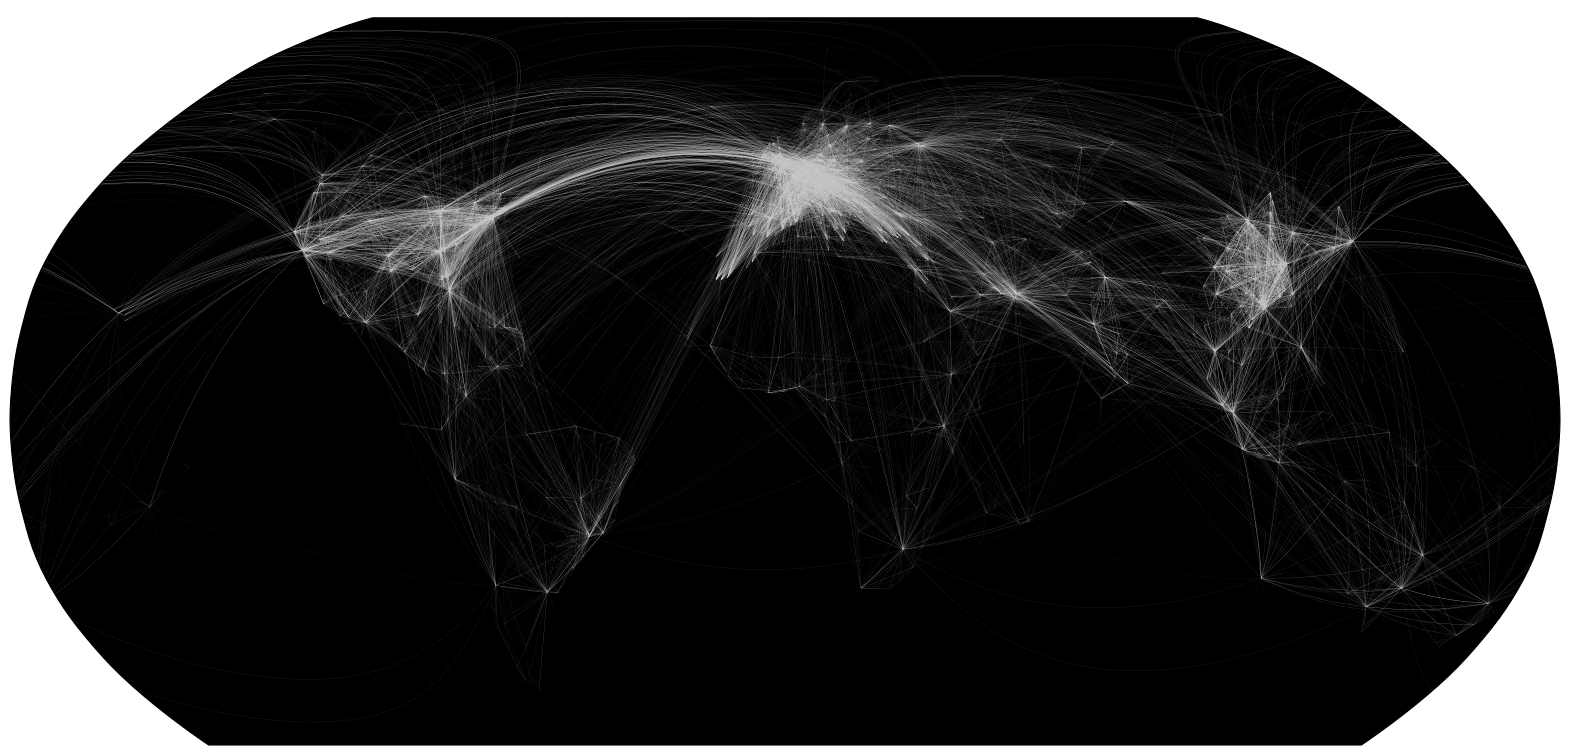

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')
routes_geodata.plot(ax=ax, 
                    transform=ccrs.Geodetic(), 
                    color='white', 
                    linewidth=0.1, 
                    alpha=0.1)
plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 8800000)
plt.show()

In [16]:
airport_source_count = routes.source_airport.value_counts()
airport_destination_count = routes.destination_airport.value_counts()

print(airport_source_count)
airport_source_count = pd.DataFrame({'airport':airport_source_count.index, 
                                     'source_airport_count':airport_source_count.values})
airport_destination_count = pd.DataFrame({'airport':airport_destination_count.index, 
                                          'destination_airport_count':airport_destination_count.values})

airport_counts = pd.merge(airport_source_count, 
                          airport_destination_count, 
                          left_on="airport", 
                          right_on="airport")


source_airport
ATL    915
ORD    558
LHR    527
PEK    525
CDG    524
      ... 
DEE      1
EKS      1
ILD      1
LEN      1
WYA      1
Name: count, Length: 3241, dtype: int64


In [17]:
airport_counts['count'] = airport_counts['source_airport_count'] + airport_counts['destination_airport_count'] 

airport_counts = pd.merge(airport_counts, 
                          airports, 
                          left_on="airport", 
                          right_on="iata")

geometry = [Point(xy) for xy in zip(airport_counts.long, 
                                    airport_counts.lat)]

airport_counts = gpd.GeoDataFrame(airport_counts, 
                                  geometry=geometry, 
                                  crs="EPSG:4326")

airport_counts['markersize'] = airport_counts['count'] / 10

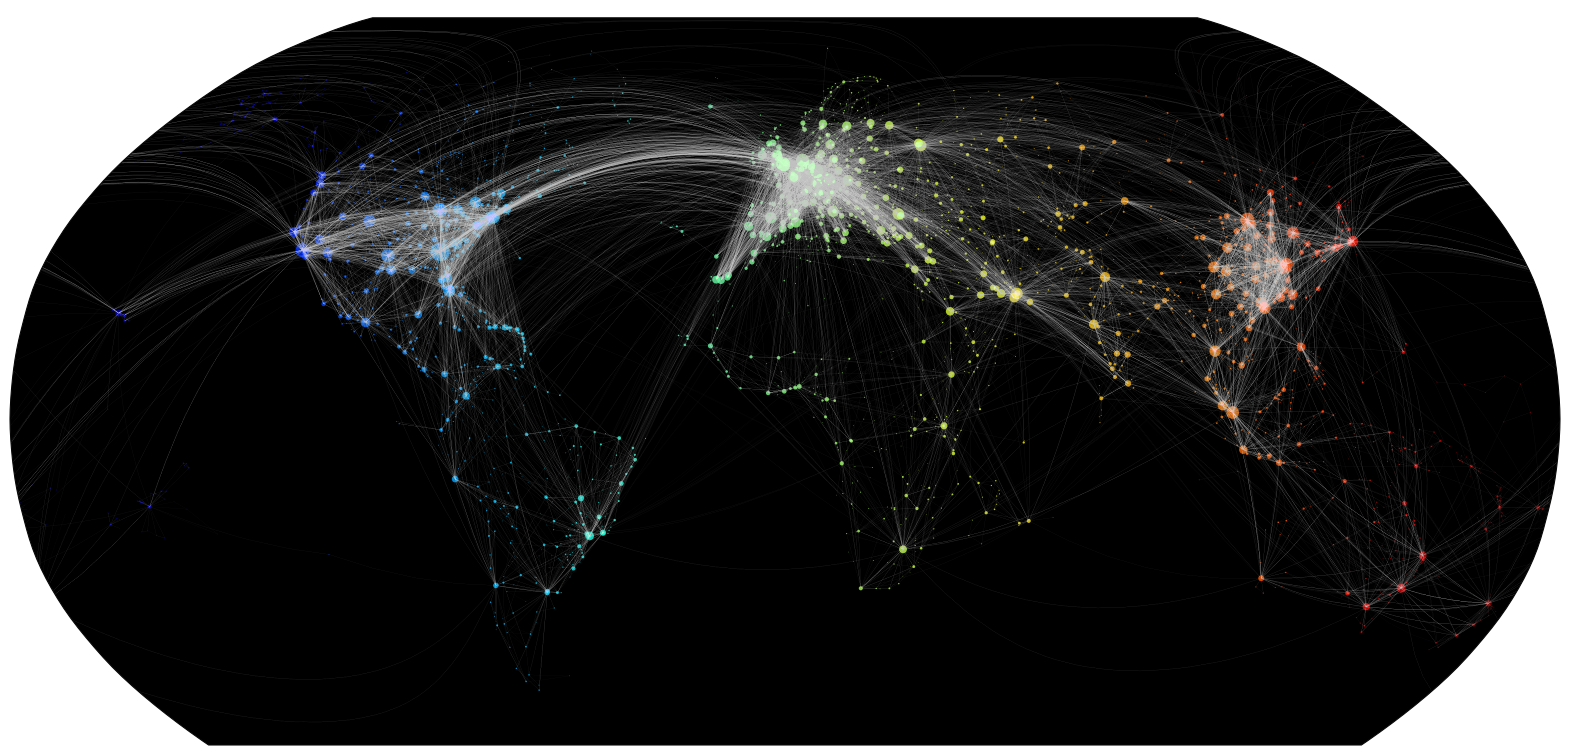

In [18]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20,20))
ax.patch.set_facecolor('black')
routes_geodata.plot(ax=ax, 
                    transform=ccrs.Geodetic(), 
                    color='white', 
                    linewidth=0.1, 
                    alpha=0.1)
airport_counts.plot(ax=ax, 
                    transform=ccrs.PlateCarree(), 
                    markersize=airport_counts['markersize'], 
                    alpha=0.8, 
                    column=airport_counts['long'], 
                    cmap='jet', 
                    edgecolors='none')

plt.setp(ax.spines.values(), color='#090909')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#090909')
ax.set_ylim(-7000000, 8800000)
plt.show()

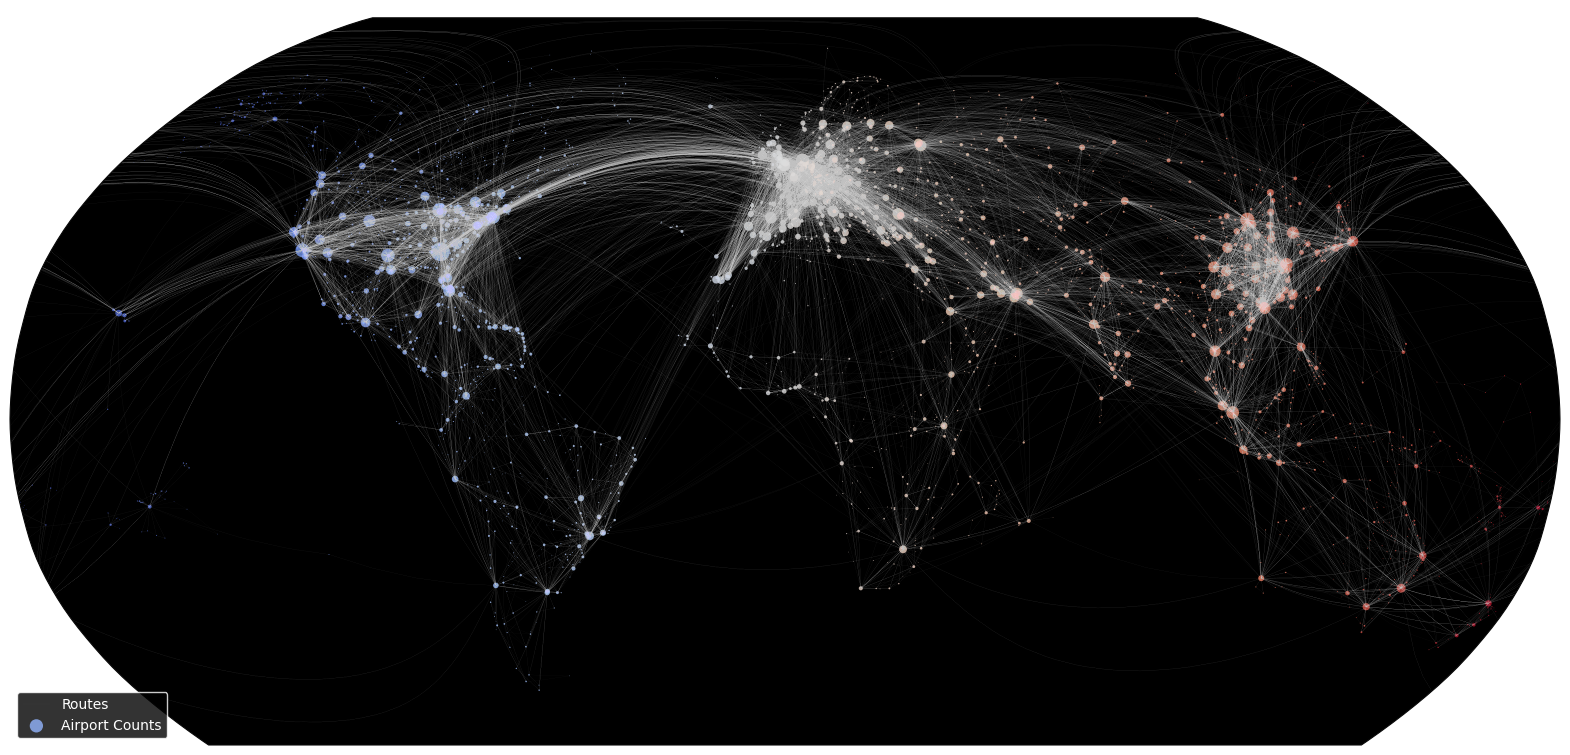

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

# Assuming you have already imported your geodata and created 'routes_geodata' and 'airport_counts' DataFrames

# Create a subplot with Robinson projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(20, 20))
ax.patch.set_facecolor('black')

# Plot routes in white with reduced alpha for a faint background
routes_geodata.plot(ax=ax, transform=ccrs.Geodetic(), color='white', linewidth=0.1, alpha=0.1, label='Routes')

# Plot airport counts with a colormap and adjusted markersize
scatter = airport_counts.plot(ax=ax, transform=ccrs.PlateCarree(), markersize=airport_counts['markersize'],
                              alpha=0.8, column=airport_counts['long'], cmap='coolwarm', edgecolors='none', label='Airport Counts')

# Set plot aesthetics
plt.setp(ax.spines.values(), color='#090909')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#090909')

# Set y-axis limits
ax.set_ylim(-7000000, 8800000)

# Create a legend
legend = ax.legend(loc='lower left', facecolor='black', edgecolor='white', labelcolor='white')

# Set legend text color to white
for text in legend.get_texts():
    text.set_color("white")

# Show the plot
plt.show()